## Model Based Collaborative Filtering Recommender

##### The goal of the recommender system is to predict user preference for a set of items based on the past experience. Two the most popular approaches are Content-Based and Collaborative Filtering. 
##### Collaborative filtering is a technique used by websites like Amazon, YouTube, and Netflix. It filters out items that a user might like on the basis of reactions of similar users. There are two categories of collaborative filtering algorithms: memory based and model based.

Model based approach involves building machine learning algorithms to predict user's ratings. They involve dimensionality reduction methods that reduce high dimensional matrix containing abundant number of missing values with a much smaller matrix in lower-dimensional space.
The goal of this section is to compare SVD and NMF algorithms, try different configurations of parameters and explore obtained results.

In [1]:
#importing the required libraries
#Data wrangling
import numpy as np
import pandas as pd
pd.set_option("display.max_colwidth",1000)#setting maximum column width
#data visualization
import seaborn as sns
sns.set_style('white')
import matplotlib.pyplot as plt
#To create wordcloud
plt.rcParams["figure.figsize"] = (8,8)
import warnings
warnings.filterwarnings('ignore')

In [2]:
d1=pd.read_csv('Preprocessed data.csv')
books_df=pd.read_csv('books_cleaned.csv')

In [3]:
ratings=pd.read_csv('ratings_cleaned.csv')

In [4]:
d1.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-L,User-ID,Book-Rating,Age,Age_group,Country
0,2005018,Clara Callan,RICHARD BRUCE WRIGHT,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg,8,5,16,Teens,CANADA
1,60973129,Decision in Normandy,CARLO D'ESTE,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.01.LZZZZZZZ.jpg,8,8,16,Teens,CANADA
2,374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,GINA BARI KOLATA,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.01.LZZZZZZZ.jpg,8,7,16,Teens,CANADA
3,399135782,The Kitchen God's Wife,AMY TAN,1991,Putnam Pub Group,http://images.amazon.com/images/P/0399135782.01.LZZZZZZZ.jpg,8,9,16,Teens,CANADA
4,425176428,What If?: The World's Foremost Military Historians Imagine What Might Have Been,ROBERT COWLEY,2000,Berkley Publishing Group,http://images.amazon.com/images/P/0425176428.01.LZZZZZZZ.jpg,8,8,16,Teens,CANADA


In [5]:
d1.columns

Index(['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher',
       'Image-URL-L', 'User-ID', 'Book-Rating', 'Age', 'Age_group', 'Country'],
      dtype='object')

In [6]:
import scipy
import math
import sklearn
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt

##### This analysis will focus on book recommendations based on Book-Crossing dataset. To reduce the dimensionality of the dataset and avoid running into memory error we will focus on users with at least 3 ratings and top 10% most frequently rated books.

The recommender systems will be built using surprise package (Matrix Factorization - based models).

In [7]:
ratings_explicit=d1[['User-ID','ISBN' ,'Book-Rating']]

In [8]:
ratings_explicit.rename(columns = {'User-ID':'user_id' ,'ISBN':'isbn' ,'Book-Rating':'book_rating','Book-Title':'book_title'},inplace=True)

In [9]:
user_ratings_threshold = 3

filter_users = ratings_explicit['user_id'].value_counts()
filter_users_list = filter_users[filter_users >= user_ratings_threshold].index.to_list()

df_ratings_top = ratings_explicit[ratings_explicit['user_id'].isin(filter_users_list)]

print('Filter: users with at least %d ratings\nNumber of records: %d' % (user_ratings_threshold, len(df_ratings_top)))

Filter: users with at least 3 ratings
Number of records: 781178


In [10]:
book_ratings_threshold_perc = 0.1
book_ratings_threshold = len(df_ratings_top['isbn'].unique()) * book_ratings_threshold_perc

filter_books_list = df_ratings_top['isbn'].value_counts().head(int(book_ratings_threshold)).index.to_list()
df_ratings_top = df_ratings_top[df_ratings_top['isbn'].isin(filter_books_list)]

print('Filter: top %d%% most frequently rated books\nNumber of records: %d' % (book_ratings_threshold_perc*100, len(df_ratings_top)))

Filter: top 10% most frequently rated books
Number of records: 448162


### SVD and NMF models comparison
Singular Value Decomposition (SVD) and Non-negative Matrix Factorization (NMF) are matrix factorization techniques used for dimensionality reduction. Surprise package provides implementation of those algorithms.

In [11]:
from surprise import Dataset, Reader
from surprise import SVD, NMF,SVDpp, SlopeOne, NormalPredictor, KNNBaseline, KNNBasic, KNNWithMeans, KNNWithZScore, BaselineOnly, CoClustering
from surprise.model_selection import cross_validate, train_test_split, GridSearchCV

In [12]:
df=df_ratings_top.copy()
reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(df[['user_id', 'isbn', 'book_rating']], reader)

In [13]:
benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), SlopeOne(), NMF(), NormalPredictor(),CoClustering(),BaselineOnly()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)

KeyboardInterrupt: 

In [ ]:
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')

In [14]:
model_svd = SVD()
cv_results_svd = cross_validate(model_svd, data, cv=3)
pd.DataFrame(cv_results_svd).mean()

test_rmse    1.119914
test_mae     0.753796
fit_time     8.349073
test_time    3.196236
dtype: float64

In [15]:
model_nmf = NMF()
cv_results_nmf = cross_validate(model_nmf, data, cv=3)
pd.DataFrame(cv_results_nmf).mean()

test_rmse     2.235850
test_mae      2.025492
fit_time     15.614914
test_time     2.902738
dtype: float64

It's clear that for the given dataset much better results can be obtained with SVD approach - both in terms of accuracy and training / testing time.

### Optimisation of SVD algorithm

##### Grid Search Cross Validation computes accuracy metrics for an algorithm on various combinations of parameters, over a cross-validation procedure. It's useful for finding the best configuration of parameters.

It is used to find the best setting of parameters:

n_factors - the number of factors

n_epochs - the number of iteration of the SGD procedure

lr_all - the learning rate for all parameters

reg_all - the regularization term for all parameters

As a result, regarding the majority of parameters, the default setting is the most optimal one. The improvement obtained with Grid Search is very small.

In [16]:
param_grid = {'n_factors': [80,100],
              'n_epochs': [5, 20],
              'lr_all': [0.002, 0.005],
              'reg_all': [0.2, 0.4]}

gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)
gs.fit(data)

print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

1.1182684832620378
{'n_factors': 80, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.2}


## Analysis of Collaborative Filtering model results

In this part, let's examine in detail the results obtained by the SVD model that provided the best RMSE score.

In [17]:
trainset, testset = train_test_split(data, test_size=0.2)

model = SVD(n_factors=80, n_epochs=20, lr_all=0.005, reg_all=0.2)
model.fit(trainset)
predictions = model.test(testset)

In [18]:
df_pred = pd.DataFrame(predictions, columns=['user_id', 'isbn', 'actual_rating', 'pred_rating', 'details'])
df_pred['impossible'] = df_pred['details'].apply(lambda x: x['was_impossible'])
df_pred['pred_rating_round'] = df_pred['pred_rating'].round()
df_pred['abs_err'] = abs(df_pred['pred_rating'] - df_pred['actual_rating'])
df_pred.drop(['details'], axis=1, inplace=True)
df_pred.sample(5)

,user_id,isbn,actual_rating,pred_rating,impossible,pred_rating_round,abs_err
45429,11676,1853261912,8.0,7.562820,False,8.0,0.437180
20284,32195,067173685X,9.0,8.075991,False,8.0,0.924009
17000,267282,316103098,10.0,9.075814,False,9.0,0.924186
64272,26593,059047071X,7.0,7.668495,False,8.0,0.668495
1117,1733,743412621,8.0,7.820300,False,8.0,0.179700


In [19]:
df_pred.sample(5).to_clipboard()

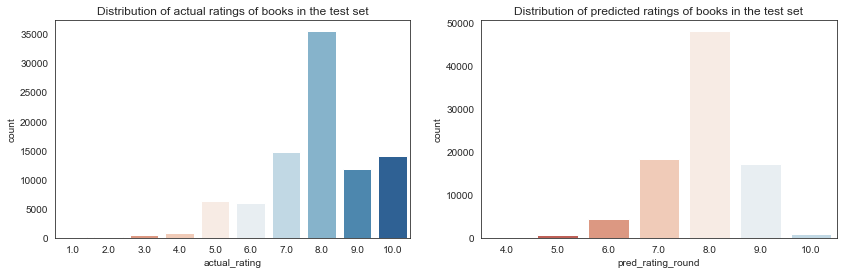

In [20]:
palette = sns.color_palette("RdBu", 10)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))

sns.countplot(x='actual_rating', data=df_pred, palette=palette, ax=ax1)
ax1.set_title('Distribution of actual ratings of books in the test set')

sns.countplot(x='pred_rating_round', data=df_pred, palette=palette, ax=ax2)
ax2.set_title('Distribution of predicted ratings of books in the test set')

plt.show()

### Absolute error of predicted ratings
The distribution of absolute errors is right-skewed, showing that the majority of errors is small: between 0 and 1. There is a long tail that indicates that there are several observations for which the absolute error was close to 10.

How good/bad the model is with predicting certain scores? As expected from the above charts, the model deals very well with predicting score = 8 (the most frequent value). The further the rating from score = 8, the higher the absolute error. The biggest errors happen to observations with scores 1 or 2 which indicates that probably the model is predicting high ratings for those observations.

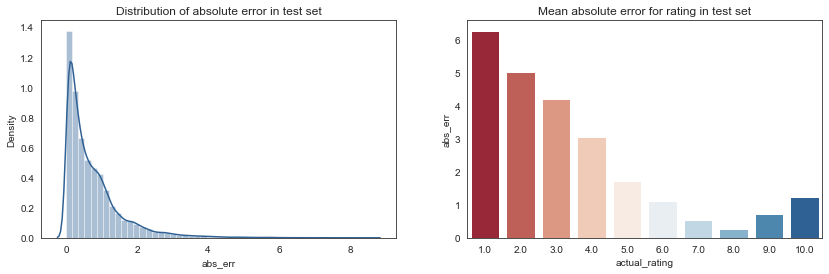

In [21]:
df_pred_err = df_pred.groupby('actual_rating')['abs_err'].mean().reset_index()

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))

sns.distplot(df_pred['abs_err'], color='#2f6194', ax=ax1)
ax1.set_title('Distribution of absolute error in test set')

sns.barplot(x='actual_rating', y='abs_err', data=df_pred_err, palette=palette, ax=ax2)
ax2.set_title('Mean absolute error for rating in test set')

plt.show()

In [22]:
df_books = books_df.copy()
df_books.rename(columns = {'ISBN':'isbn' ,'Book-Title':'book_title'},inplace=True)
df_ext = df.merge(df_books[['isbn', 'book_title']], on='isbn', how='left')
df_ext = df_ext.merge(df_pred[['isbn', 'user_id', 'pred_rating']], on=['isbn', 'user_id'], how='left')

### Train set: Top rated books

In [23]:
selected_user_id = 193458
df_user = df_ext[df_ext['user_id']==selected_user_id]

df_user[(df_user['pred_rating'].isna())&(df_user['book_rating']>=9)].sample(10)

,user_id,isbn,book_rating,book_title,pred_rating
150178,193458,330352695,9,Four Letters of Love,NaN
150206,193458,345342569,9,Shoeless Joe,NaN
150180,193458,006447108X,9,The Last Battle,NaN
150171,193458,440418321,10,"The Golden Compass (His Dark Materials, Book 1)",NaN
150186,193458,345431057,9,Slaves in the Family (Ballantine Reader's Circle),NaN
150195,193458,440181488,9,Son: A Psychopath and His Victims,NaN
150192,193458,64471055,9,Prince Caspian (rack) : The Return to Narnia (Narnia),NaN
150170,193458,671880314,9,Schindler's List,NaN
150158,193458,1400032806,9,Under the Banner of Heaven : A Story of Violent Faith,NaN
150142,193458,140620125,9,Wuthering Heights (Penguin Popular Classics),NaN


### Test set: predicted top rated books

In [24]:
df_user[df_user['pred_rating'].notna()].sort_values('pred_rating', ascending=False).head(5)

,user_id,isbn,book_rating,book_title,pred_rating
150140,193458,345413377,10,"The Amber Spyglass (His Dark Materials, Book 3)",8.981631
150145,193458,345361792,10,A Prayer for Owen Meany,8.942030
150173,193458,64471047,9,"The Lion, the Witch, and the Wardrobe (The Chronicles of Narnia, Book 2)",8.892989
150138,193458,1853260622,5,War and Peace (Wordsworth Classics),8.748027
150191,193458,64471063,9,The Horse and His Boy,8.513531


### Test set: actual top rated books

In [25]:
df_user[df_user['pred_rating'].notna()].sort_values('book_rating', ascending=False).head(5)

,user_id,isbn,book_rating,book_title,pred_rating
150140,193458,345413377,10,"The Amber Spyglass (His Dark Materials, Book 3)",8.981631
150145,193458,345361792,10,A Prayer for Owen Meany,8.942030
150163,193458,1853260002,10,Pride &amp; Prejudice (Wordsworth Classics),8.498312
150133,193458,679429220,9,Midnight in the Garden of Good and Evil: A Savannah Story,7.776665
150173,193458,64471047,9,"The Lion, the Witch, and the Wardrobe (The Chronicles of Narnia, Book 2)",8.892989


In [38]:
predicted=df_user[df_user['pred_rating'].notna()].sort_values('pred_rating', ascending=False).head(5)

In [39]:
predicted.rename(columns = {'isbn':'ISBN'}, inplace = True)

In [40]:
from PIL import Image
import warnings
warnings.filterwarnings('ignore')
import requests

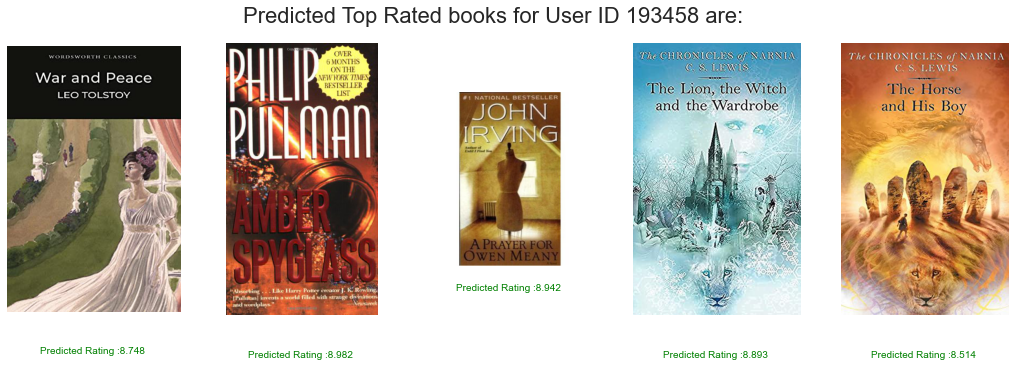

In [41]:
author_recc=pd.merge(books_df,predicted,how='inner',on='ISBN')
fig, axs = plt.subplots(1,5 ,figsize=(18,5))

fig.suptitle('Predicted Top Rated books for User ID '+str('193458')+' are:\n  ', size = 22)
for i in range(len(author_recc['Book-Title'].tolist())):
    url = books_df.loc[books_df['ISBN'] == author_recc['ISBN'].tolist()[i],'Image-URL-L'][:1].values[0]
    headers ={
    'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.114 Safari/537.36'
}
    im = Image.open(requests.get(url,headers=headers, stream=True).raw)
    axs[i].imshow(im)
    axs[i].axis("off")
    axs[i].set_title('Predicted Rating :{} '.format(round(author_recc['pred_rating'][i],3)),
                             y=-0.18,
                                 color="green",
                                 fontsize=10)
    fig.show()


In [42]:
actual=df_user[df_user['pred_rating'].notna()].sort_values('book_rating', ascending=False).head(5)
actual.rename(columns = {'isbn':'ISBN'}, inplace = True)

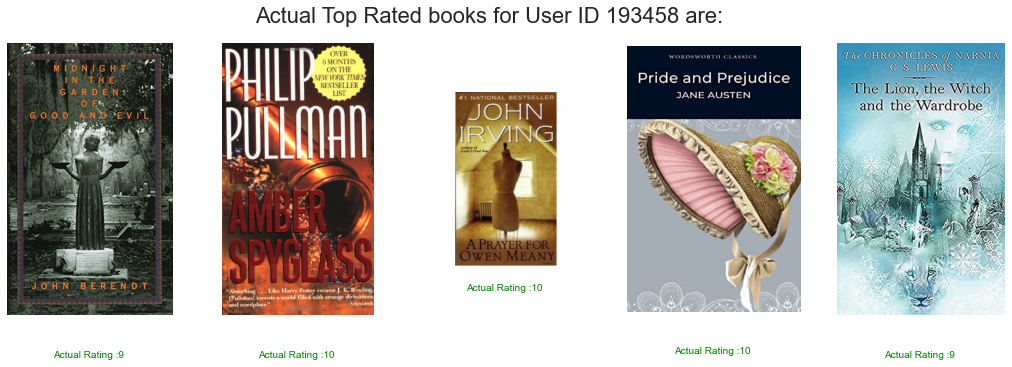

In [44]:
author_recc=pd.merge(books_df,actual,how='inner',on='ISBN')
fig, axs = plt.subplots(1,5 ,figsize=(18,5))

fig.suptitle('Actual Top Rated books for User ID '+str('193458')+' are:\n  ', size = 22)
for i in range(len(author_recc['Book-Title'].tolist())):
    url = books_df.loc[books_df['ISBN'] == author_recc['ISBN'].tolist()[i],'Image-URL-L'][:1].values[0]
    headers ={
    'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.114 Safari/537.36'
}
    im = Image.open(requests.get(url,headers=headers, stream=True).raw)
    axs[i].imshow(im)
    axs[i].axis("off")
    axs[i].set_title('Actual Rating :{} '.format(round(author_recc['book_rating'][i],3)),
                             y=-0.18,
                                 color="green",
                                 fontsize=10)
    fig.show()
